# First simulation 

In this notebook, we run some experiments on simulated data of **Hitting Time Prediction**.

In [1]:
import numpy as np
np.random.seed(0)
import torch
torch.manual_seed(0)
import matplotlib.pyplot as plt
from time import time

import warnings
warnings.filterwarnings('ignore')

### Data generation & preprocessing

***Generate longitudinal markers***

**Paths** The paths are $5$-dimensional sample paths of a fractionnal brownian motion sampled at $100$ times over the time interval $[0,10]$. The different dimensions are independent. 

**Event definition** We consider the stochastic differential equation
\begin{align}
    \label{eq:experiment_1_cde}
    dw_t & = -\theta\big(w_t-\mu\big)dt + (1,\dots,1)^\top d\mathbf{X}_t\\
    & = -\theta\big(w_t-\mu\big)dt + \sum\limits_{j=1}^d d\mathbf{X}^{(j)}_t
\end{align}
driven by the data, which we solve by computing its Euler-Maruyama discretization through 
\begin{align}
    w_{t+\Delta t} = w_t - \theta(w_t - \mu)\Delta t + \sum\limits_{j=1}^d \Delta \mathbf{X}^{(j)}_t.
\end{align}

We define the time-of-event as 
\begin{align}
    T^\star = \min \{ t_1 \leq t \leq t_N  s.t. w_t \geq \kappa\}
\end{align}
where $\kappa \in \mathbb{R}$ is a threshold value i.e. the time-of-event is the hitting time of the barrier $\kappa$ of the solution to CDE. In this experiment, we set $\kappa=2.5$.

**Censorship** We censor individuals whose trajectory does not cross the threshold during the observation period. This means that individuals are never censored during the observation period, but only at the end.  

In [2]:
from data_loader import load_OU
paths, surv_labels, ddh_info_sup = load_OU.load()
n_samples, n_sampling_times, _ = paths.shape
sampling_times = paths[0, :, 0]
surv_times, surv_inds = surv_labels[:, 0], surv_labels[:, 1]
paths_init = paths.clone() # for MC true survival function

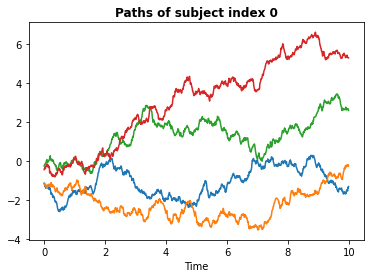

In [3]:
# plot time series of subject index 0
idx = 0
plt.plot(sampling_times, paths[idx,:,1:])
plt.xlabel("Time")
plt.ylabel("")
plt.title("Paths of subject index 0", fontweight="bold", size=12)
plt.show()

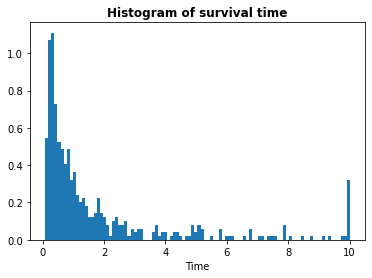

In [4]:
plt.hist(surv_times, bins=100, density=True)
plt.xlabel("Time")
plt.title("Histogram of survival time", fontweight="bold")
plt.show()

In [5]:
#Number of individuals
print("Number of samples ", paths.shape[0])
#Number of individuals
print("Number of longitudinal markers ", paths.shape[2])
#Censoring level
print("Censoring level {}%".format(((1 - sum(surv_inds) / len(surv_inds)) * 100).round(1)))

Number of samples  500
Number of longitudinal markers  5
Censoring level 3.2%


***Masking***

We need to flatten the curves that appear after the event for the train test. First we have to put the events on the time grid.

In [6]:
# index of individuals for whom the event occurs
occuring_event_index = np.where(surv_labels[:,1] == 1)[0]
for idx in occuring_event_index:
    time_index = np.searchsorted(sampling_times, surv_labels[idx, 0])
    if time_index < n_sampling_times:
        paths[idx, time_index:, 1:] = paths[idx, time_index, 1:]

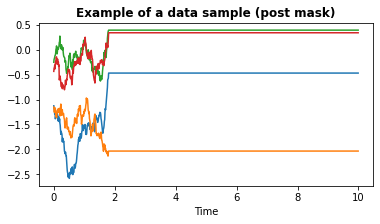

In [7]:
idx = 0
plt.figure(figsize=(6, 3))
plt.plot(sampling_times, paths[idx, :, 1:])
plt.title("Example of a data sample (post mask)", fontweight="bold")
plt.xlabel("Time")
plt.show()

***Setup for prediction***

In [8]:
sampling_times = np.array(paths[0, :, 0])
tte = surv_labels[surv_labels[:, 1] == 1][:, 0]
quantile_pred_times = np.array([.1, .25, .5])
pred_times = np.quantile(np.array(tte), quantile_pred_times)
n_eval_times = 3
eval_times = []
for k in range(n_eval_times):
    eval_times.append(max(np.quantile(np.array(tte), quantile_pred_times + (k+1) * .05) - pred_times))
eval_times = np.array(eval_times)

***Split train-test data***

In [9]:
train_test_share = .8
n_samples = paths.shape[0]
n_train_samples = int(train_test_share * n_samples)
train_index = np.random.choice(n_samples, n_train_samples, replace=False)
test_index = [i for i in np.arange(n_samples) if i not in train_index]

paths_train = paths[train_index, :, :]
surv_labels_train = surv_labels[train_index, :]

paths_test = paths[test_index, :, :]
surv_labels_test = surv_labels[test_index, :]

### Neural Controlled Differential Equation (NCDE)

epoch: 0, objective: 7.509518384933472
epoch: 1, objective: 7.213411092758179
epoch: 2, objective: 7.022666811943054
epoch: 3, objective: 6.894009232521057
epoch: 4, objective: 6.803541898727417
epoch: 5, objective: 6.732996225357056
epoch: 6, objective: 6.67017936706543
epoch: 7, objective: 6.6097999811172485
epoch: 8, objective: 6.55159729719162
epoch: 9, objective: 6.496805191040039
epoch: 10, objective: 6.445740282535553
epoch: 11, objective: 6.397892892360687
epoch: 12, objective: 6.352923154830933
epoch: 13, objective: 6.310797691345215
epoch: 14, objective: 6.271417796611786
epoch: 15, objective: 6.234546780586243
epoch: 16, objective: 6.199943900108337
epoch: 17, objective: 6.167371511459351
epoch: 18, objective: 6.136540234088898
epoch: 19, objective: 6.107145190238953
epoch: 20, objective: 6.07891845703125
epoch: 21, objective: 6.051644027233124
epoch: 22, objective: 6.025136053562164
epoch: 23, objective: 5.99923038482666
epoch: 24, objective: 5.973785698413849
epoch: 25, ob

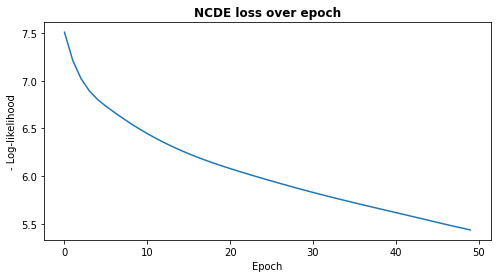

In [10]:
from src.cresnet import ControlledResNet

latent_dim = 4
hidden_dim = 128
path_dim = paths_train.shape[-1]
activation = 'tanh'
n_layers=2
learning_rate = 1e-4
batch_size = 64
num_epochs = 50
ncde = ControlledResNet(latent_dim, hidden_dim, path_dim, 
                        activation, n_layers, sampling_times)
ncde_optimizer = torch.optim.Adam(ncde.parameters(),
                                  lr=learning_rate)
start = time()
ncde.train(ncde_optimizer, paths_train, surv_labels_train, 
           batch_size, num_epochs, verbose=True)
ncde_bs = ncde.score(paths_test, surv_labels_test, pred_times, eval_times, "bs")
ncde_cindex = ncde.score(paths_test, surv_labels_test, pred_times, eval_times, 'c_index')
ncde_auc = ncde.score(paths_test, surv_labels_test, pred_times, eval_times, 'auc')
ncde_time = time() - start

### Cox Signature

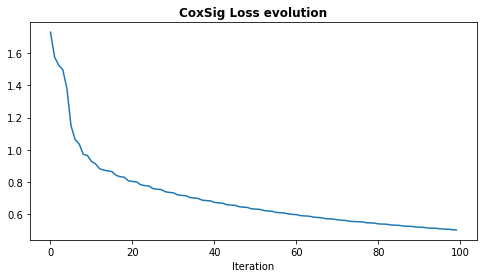

In [11]:
from src.coxsig import CoxSignature
# model with unnormalized features
start = time()
coxsig = CoxSignature(sig_level=2, alphas=1e-2, max_iter=100, plot_loss=True)
coxsig.train(paths_train, surv_labels_train)
coxsig_bs = coxsig.score(paths_test, surv_labels_test, pred_times, eval_times, "bs")
coxsig_cindex = coxsig.score(paths_test, surv_labels_test, pred_times, eval_times, 'c_index')
coxsig_auc = coxsig.score(paths_test, surv_labels_test, pred_times, eval_times, 'auc')
coxsig_time = time() - start

### Cox Signature Extension

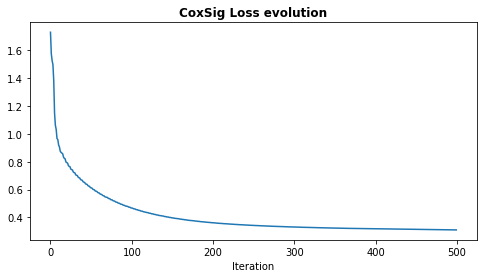

In [13]:
start = time()
coxsigext = CoxSignature(sig_level=2, alphas=1e-5, max_iter=500, plot_loss=True, ext_ver=True)
coxsigext.train(paths_train, surv_labels_train)
coxsigext_bs = coxsigext.score(paths_test, surv_labels_test, pred_times, eval_times, "bs")
coxsigext_cindex = coxsigext.score(paths_test, surv_labels_test, pred_times, eval_times, 'c_index')
coxsigext_auc = coxsigext.score(paths_test, surv_labels_test, pred_times, eval_times, 'auc')
coxsigext_time = time() - start

### Competing methods ###

### CoxFirst

In [14]:
from competing_methods.coxfirst import CoxFirst
start = time()
coxfirst = CoxFirst(alphas=np.array([1e-3]))
coxfirst.train(paths_train, surv_labels_train)
coxfirst_bs = coxfirst.score(paths_test, surv_labels_test, pred_times, eval_times, "bs")
coxfirst_cindex = coxfirst.score(paths_test, surv_labels_test, pred_times, eval_times, 'c_index')
coxfirst_auc = coxfirst.score(paths_test, surv_labels_test, pred_times, eval_times, 'auc')
coxfirst_time = time() - start

### RSF

In [15]:
from competing_methods.rsf import RSF
start = time()
rsf = RSF()
rsf.train(paths_train, surv_labels_train)
rsf_bs = rsf.score(paths_test, surv_labels_test, pred_times, eval_times, "bs")
rsf_cindex = rsf.score(paths_test, surv_labels_test, pred_times, eval_times, 'c_index')
rsf_auc = rsf.score(paths_test, surv_labels_test, pred_times, eval_times, 'auc')
rsf_time = time() - start

### Dynamic-DeepHit

In [16]:
from competing_methods.dynamic_deephit_ext import construct_df, Dynamic_DeepHit_ext
from src.utils import score


INFO:tensorflow:Scale of 0 disables regularizer.

BURN-IN TRAINING ...
itr: 0010 | loss: 300.8106
itr: 0020 | loss: 374.6335
itr: 0030 | loss: 437.5045
itr: 0040 | loss: 287.1000
itr: 0050 | loss: 187.4144
MAIN TRAINING ...
itr: 0010 | loss: 197.7280
itr: 0020 | loss: 123.7661
itr: 0030 | loss: 92.1390
itr: 0040 | loss: 163.9573
itr: 0050 | loss: 106.1237
itr: 0060 | loss: 88.4975
itr: 0070 | loss: 78.8854
itr: 0080 | loss: 75.6158
itr: 0090 | loss: 79.7894
itr: 0100 | loss: 76.7136
itr: 0110 | loss: 66.7029
itr: 0120 | loss: 67.2655
itr: 0130 | loss: 52.9335
itr: 0140 | loss: 64.6716
itr: 0150 | loss: 52.7998
itr: 0160 | loss: 62.7055
itr: 0170 | loss: 63.7902
itr: 0180 | loss: 44.2151
itr: 0190 | loss: 60.6094
itr: 0200 | loss: 75.3408
itr: 0210 | loss: 56.2386
itr: 0220 | loss: 65.7022
itr: 0230 | loss: 69.9019
itr: 0240 | loss: 63.1526
itr: 0250 | loss: 59.0648


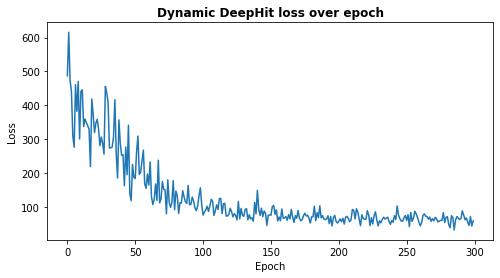

In [18]:
start = time()
# set-up for Dynamic DeepHit
cont_feat, bin_feat, time_scale, bin_df = ddh_info_sup
df = construct_df(paths.clone(), surv_labels, cont_feat, bin_feat, time_scale, bin_df)
dynamic_deephit = Dynamic_DeepHit_ext()
(data, time_, label), (mask1, mask2, mask3), (data_mi) = dynamic_deephit.preprocess(df, cont_feat)

# split data
tr_data, te_data = data[train_index, :, :], data[test_index, :, :]
tr_data_mi, te_data_mi = data_mi[train_index, :, :], data_mi[test_index, :, :]
tr_time,te_time = time_[train_index, :], time_[test_index, :]
tr_label,te_label = label[train_index, :], label[test_index, :]
tr_mask1,te_mask1 = mask1[train_index, :, :], mask1[test_index, :, :]
tr_mask2,te_mask2 = mask2[train_index, :, :], mask2[test_index, :, :]
tr_mask3,te_mask3 = mask3[train_index, :], mask3[test_index, :]

tr_data_full = (tr_data, tr_data_mi, tr_label, tr_time, tr_mask1, tr_mask2, tr_mask3)

# train
dynamic_deephit.train(tr_data_full, sess_path=".", is_trained=False)

# predict
pred_time_scale = (pred_times * time_scale).astype(int)
eval_time_scale = (eval_times * time_scale).astype(int)
ddh_surv_preds = dynamic_deephit.predict(te_data, te_data_mi, 
                                         pred_time_scale, eval_time_scale)

n_pred_times = len(pred_times)
n_eval_times = len(eval_times)
ddh_bs = np.zeros((n_pred_times, n_eval_times))
ddh_cindex = np.zeros((n_pred_times, n_eval_times))
ddh_auc = np.zeros((n_pred_times, n_eval_times))
for j in np.arange(n_pred_times):
    pred_time = pred_times[j]
    
    # remove individuals whose survival time less than prediction time
    surv_times_test = surv_labels_test[:, 0]
    surv_inds_test = surv_labels_test[:, 1]
    idx_sel = surv_times_test >= pred_time
    surv_times_ = surv_times_test[idx_sel] - pred_time
    surv_inds_ = surv_inds_test[idx_sel]
    surv_labels_ = np.array([surv_times_, surv_inds_]).T
    surv_preds_ = ddh_surv_preds[:, j][idx_sel]

    ddh_bs[j] = score("bs", surv_labels_, surv_labels_, 
                      surv_preds_, eval_times)
    ddh_cindex[j] = score("c_index", surv_labels_, surv_labels_, 
                          surv_preds_, eval_times)
    ddh_auc[j] = score("auc", surv_labels_, surv_labels_, 
                          surv_preds_, eval_times)

ddh_time = time() - start

***Performace evaluation***

***C_index***

In [24]:
import prettytable
from prettytable import PrettyTable
cindex_table = PrettyTable()
cindex_table.field_names = ["p_t", "Model"] + ["d_t = "+str(t.round(3)) for t in eval_times]
for i in range(len(pred_times)):
    t = round(pred_times[i], 3)
    cindex_table.add_row(["", "NCDE"] + ncde_cindex[i].round(3).tolist())
    cindex_table.add_row(["", "CoxSig"] + coxsig_cindex[i].round(3).tolist())
    cindex_table.add_row([t, "CoxSigExt"] + coxsigext_cindex[i].round(3).tolist())
    cindex_table.add_row(["", "CoxFirst"] + coxfirst_cindex[i].round(3).tolist())
    cindex_table.add_row(["", "RSF"] + rsf_cindex[i].round(3).tolist())
    cindex_table.add_row(["", "Dyn_DeepHit"] + ddh_cindex[i].round(3).tolist())
    cindex_table.add_row([""]*5)
print(cindex_table)

+-------+-------------+-----------+------------+------------+
|  p_t  |    Model    | d_t = 0.1 | d_t = 0.25 | d_t = 0.43 |
+-------+-------------+-----------+------------+------------+
|       |     NCDE    |   0.495   |    0.48    |   0.457    |
|       |    CoxSig   |   0.799   |   0.796    |   0.786    |
|  0.23 |  CoxSigExt  |   0.803   |   0.796    |   0.781    |
|       |   CoxFirst  |   0.564   |   0.592    |   0.607    |
|       |     RSF     |    0.45   |   0.431    |   0.422    |
|       | Dyn_DeepHit |   0.515   |   0.513    |   0.496    |
|       |             |           |            |            |
|       |     NCDE    |   0.588   |   0.536    |   0.556    |
|       |    CoxSig   |   0.875   |   0.815    |   0.798    |
| 0.357 |  CoxSigExt  |    0.87   |   0.811    |    0.79    |
|       |   CoxFirst  |    0.64   |   0.642    |   0.574    |
|       |     RSF     |   0.326   |   0.473    |   0.405    |
|       | Dyn_DeepHit |   0.629   |   0.528    |   0.578    |
|       

***Brier-score***

In [25]:
import prettytable
from prettytable import PrettyTable
bs_table = PrettyTable()
bs_table.field_names = ["p_t", "Model"] + ["d_t = "+str(t.round(3)) for t in eval_times]
for i in range(len(pred_times)):
    t = round(pred_times[i], 3)
    bs_table.add_row(["", "NCDE"] + ncde_bs[i].round(3).tolist())
    bs_table.add_row(["", "CoxSig"] + coxsig_bs[i].round(3).tolist())
    bs_table.add_row([t, "CoxSigExt"] + coxsigext_bs[i].round(3).tolist())
    bs_table.add_row(["", "CoxFirst"] + coxfirst_bs[i].round(3).tolist())
    bs_table.add_row(["", "RSF"] + rsf_bs[i].round(3).tolist())
    bs_table.add_row(["", "Dyn_DeepHit"] + ddh_bs[i].round(3).tolist())
    bs_table.add_row([""]*5)
print(bs_table)

+-------+-------------+-----------+------------+------------+
|  p_t  |    Model    | d_t = 0.1 | d_t = 0.25 | d_t = 0.43 |
+-------+-------------+-----------+------------+------------+
|       |     NCDE    |   0.161   |    0.2     |   0.255    |
|       |    CoxSig   |   0.141   |   0.158    |   0.185    |
|  0.23 |  CoxSigExt  |   0.131   |   0.147    |   0.171    |
|       |   CoxFirst  |   0.151   |   0.188    |   0.231    |
|       |     RSF     |   0.152   |   0.199    |    0.25    |
|       | Dyn_DeepHit |   0.176   |   0.239    |   0.342    |
|       |             |           |            |            |
|       |     NCDE    |   0.072   |   0.185    |   0.229    |
|       |    CoxSig   |   0.062   |   0.146    |   0.172    |
| 0.357 |  CoxSigExt  |   0.058   |   0.142    |   0.168    |
|       |   CoxFirst  |   0.072   |   0.177    |   0.222    |
|       |     RSF     |   0.077   |   0.185    |   0.235    |
|       | Dyn_DeepHit |   0.076   |   0.219    |   0.301    |
|       

***AUC***

In [26]:
import prettytable
from prettytable import PrettyTable
auc_table = PrettyTable()
auc_table.field_names = ["p_t", "Model"] + ["d_t = "+str(t.round(3)) for t in eval_times]
for i in range(len(pred_times)):
    t = round(pred_times[i], 3)
    auc_table.add_row(["", "NCDE"] + ncde_auc[i].round(3).tolist())
    auc_table.add_row(["", "CoxSig"] + coxsig_auc[i].round(3).tolist())
    auc_table.add_row([t, "CoxSigExt"] + coxsigext_auc[i].round(3).tolist())
    auc_table.add_row(["", "CoxFirst"] + coxfirst_auc[i].round(3).tolist())
    auc_table.add_row(["", "RSF"] + rsf_auc[i].round(3).tolist())
    auc_table.add_row(["", "Dyn_DeepHit"] + ddh_auc[i].round(3).tolist())
    auc_table.add_row([""]*5)
print(auc_table)

+-------+-------------+-----------+------------+------------+
|  p_t  |    Model    | d_t = 0.1 | d_t = 0.25 | d_t = 0.43 |
+-------+-------------+-----------+------------+------------+
|       |     NCDE    |   0.495   |   0.468    |    0.42    |
|       |    CoxSig   |   0.812   |   0.826    |   0.839    |
|  0.23 |  CoxSigExt  |   0.818   |   0.827    |    0.83    |
|       |   CoxFirst  |   0.555   |   0.605    |   0.645    |
|       |     RSF     |   0.448   |   0.401    |   0.402    |
|       | Dyn_DeepHit |   0.515   |   0.513    |    0.48    |
|       |             |           |            |            |
|       |     NCDE    |   0.577   |   0.524    |   0.549    |
|       |    CoxSig   |    0.89   |   0.838    |   0.836    |
| 0.357 |  CoxSigExt  |    0.88   |   0.827    |   0.824    |
|       |   CoxFirst  |   0.648   |   0.664    |   0.569    |
|       |     RSF     |   0.329   |   0.489    |   0.393    |
|       | Dyn_DeepHit |   0.634   |   0.522    |   0.599    |
|       

***Running time***

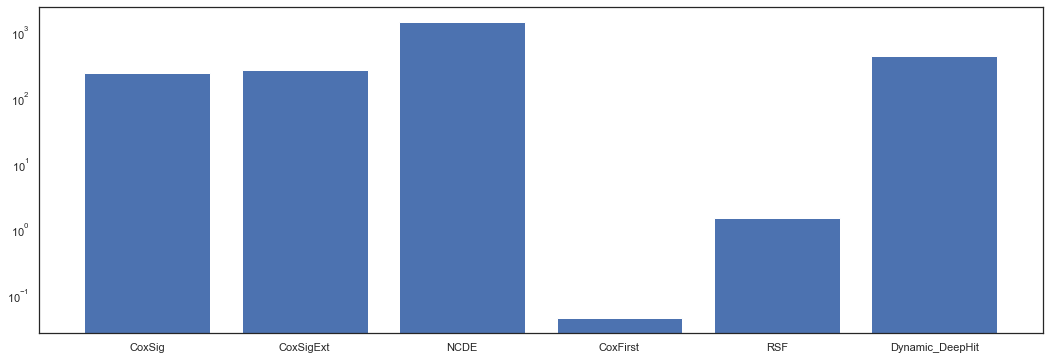

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white")

plt.figure(figsize=(18, 6))
plt.bar(["CoxSig", 
         "CoxSigExt",
         "NCDE", 
         "CoxFirst", 
         "RSF", 
         "Dynamic_DeepHit"], 
        [coxsig_time, 
         coxsigext_time, 
         ncde_time, 
         coxfirst_time, 
         rsf_time, 
         ddh_time])
plt.yscale("log")